# Setup

## Check Python version

In [121]:
from platform import  python_version

In [122]:
python_version()

'3.10.5'

## Install/Download necessary packages

In [123]:
import sys

In [124]:
# # Uncomment these if any packages are not installed in your current jupyter env 
# # Installing a pip package in the current kernel
# # Pandas also installs the numpy package
# !{sys.executable} -m pip install pandas  
# !{sys.executable} -m pip install requests
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install featuretools
# !{sys.executable} -m pip install seaborn

In [125]:
# import the required packages (more imported in the model section)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import featuretools as ft
from featuretools.selection import selection
from IPython.core.interactiveshell import InteractiveShell 
from IPython.display import Image  
import inspect
from functools import reduce

In [126]:
# import warnings
# warnings.filterwarnings('ignore')

# Importing and Preprocessing the Data

In [127]:
def view_files():
    path = os.getcwd()
    path = f"{path}\data"
    return(os.listdir(path))

view_files()

['absa2.csv',
 'absa_jup.csv',
 'AllShares_growth.csv',
 'banks_data.csv',
 'capitec.csv',
 'feature_imp_select.csv',
 'fnb.csv',
 'household_financial_assets-currency_and_deposits.csv',
 'investec.csv',
 'investment_Qgrowth.csv',
 'inv_by_assets_intellectual.csv',
 'nedbank.csv',
 'share_prices.csv',
 'standard_bank.csv']

## Importing and Cleaning

In [128]:
def check_file(file):
    #grab the file path from which to import the dataset
    path = os.getcwd()
    path = f"{path}\data"
    path = f"{path}\{file}"
    return(path)

In [129]:
check_file("absa.csv")

'C:\\GitHub\\DS_PROJ\\data\\absa.csv'

In [130]:
def import_data(path):
    # read the csv file as a dataframe and remove unnecessary columns
    df = pd.read_csv(filepath_or_buffer=path)
    return(df)

In [131]:
absa = import_data(check_file("absa2.csv"))
absa.head(1)

,Bank,Unit,Table,Time series code,D_M_1993M01: 1993M01,D_M_1993M02: 1993M02,D_M_1993M03: 1993M03,D_M_1993M04: 1993M04,D_M_1993M05: 1993M05,D_M_1993M06: 1993M06,...,D_M_2021M07: 2021M07,D_M_2021M08: 2021M08,D_M_2021M09: 2021M09,D_M_2021M10: 2021M10,D_M_2021M11: 2021M11,D_M_2021M12: 2021M12,D_M_2022M01: 2022M01,D_M_2022M02: 2022M02,D_M_2022M03: 2022M03,D_M_2022M04: 2022M04
0,B_34118: Absa Bank Ltd,U_RT: R'000 (thousands),T_T01: Table 1: LIABILITIES AT MONTH-END,RBD-B_34118-T_T01-U_RT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data is not stored in the format typically useful for the pandas framework.

First, the unnecessary variables/indicators such as `Units` and `Time series code"` 

is be removed or transformed and the excessive variable naming trimmed.

In [132]:
def clean_names1(df, bank_prefix="B_34118: "):
    df = df.drop(["Unit", "Time series code"], axis="columns")
    
    # Remove ugly string labels of columns
    df.columns = df.columns.str.replace(pat="D_M_[0-9]{4}M[0-9]{2}:", repl="", regex=True)
    df["Bank"] = df["Bank"].str.replace(pat=bank_prefix, repl="", regex=True)
    df["Bank"] = df["Bank"].str.replace(pat = " ", repl = "_")
    return(df)
    

In [133]:
absa = clean_names1(absa)

In [134]:
absa.head(1)

,Bank,Table,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,...,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03,2022M04
0,Absa_Bank_Ltd,T_T01: Table 1: LIABILITIES AT MONTH-END,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below is a check to ensure that all the rows that have lable 

`T_T[0-9]{2}R[0-9]{3}:` or `T_T[0-9]{2}R[0-9]{3}_A:` do not

contain any observations and can therefore be removed

In [135]:
InteractiveShell.ast_node_interactivity = "all"

In [136]:
all(absa[absa["Table"].str.contains("T_T[0-9]{2}R[0-9]{3}:", 
                                    regex = True)].isna().sum(axis=1, 
                                                              skipna=False) == len(absa.columns) - 2);
all(absa[absa["Table"].str.contains("T_T[0-9]{2}R[0-9]{3}_A:", 
                                    regex = True)].isna().sum(axis=1, 
                                                              skipna=False) == len(absa.columns) - 2)

True

True

In [137]:
InteractiveShell.ast_node_interactivity = "last"

Now, we can remove the rows that contain the labels

mentioned above

In [138]:
def remove_empty(df):
    # Remove empty title rows
    df = df[~df["Table"].str.contains("T_T[0-9]{2}R[0-9]{3}:", regex = True)]
    df = df[~df["Table"].str.contains("T_T[0-9]{2}R[0-9]{3}_A:", regex = True)]
    
    return(df)

In [139]:
absa = remove_empty(absa)

In [140]:
absa.head(1)

,Bank,Table,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,...,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03,2022M04
0,Absa_Bank_Ltd,T_T01: Table 1: LIABILITIES AT MONTH-END,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
# absa.loc[absa["Table"].str.contains("T_T01R[0-9]{3}C[0-9]{2}: T01R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
#                                regex=True), :].iloc[:,1:3].set_index("Table").head(15)

absa.loc[absa["Table"].str.contains("T_T01R001|T_T01R002|T_T02R032", 
                               regex=True), :].iloc[:,1:3].set_index("Table")

,1993M01
Table,
T_T01R001C01: T01R001C01: DEPOSITS (total of items 2 and 32): Cheque (1),9588342.0
T_T01R001C02: T01R001C02: DEPOSITS (total of items 2 and 32): Savings (2),7800740.0
T_T01R001C03: T01R001C03: DEPOSITS (total of items 2 and 32): Up to 1 day (3),8946659.0
T_T01R001C04: T01R001C04: DEPOSITS (total of items 2 and 32): More than 1 day to 1 month (4),9417927.0
T_T01R001C05: T01R001C05: DEPOSITS (total of items 2 and 32): More than 1 month to 6 months (5),21301640.0
T_T01R001C06: T01R001C06: DEPOSITS (total of items 2 and 32): More than 6 months (6),8981624.0
T_T01R001C07: T01R001C07: DEPOSITS (total of items 2 and 32): TOTAL (7),66036932.0
T_T01R001C08: T01R001C08: DEPOSITS (total of items 2 and 32): NCDs/PNs i (included in col. 7) (8),NaN
"T_T01R002C01: T01R002C01: DEPOSITS DENOMINATED IN RAND (total of items 3, 6, 12, 13 and 29): Cheque (1)",9588342.0


In [142]:
66034650.0 + 2282.0 == 66036932.0

# i.e. what we have above is
r_001 = absa.loc[absa["Table"].str.contains("DEPOSITS [(]total of items 2 and 32[)]: TOTAL [(]7[)]"),
        :].iloc[:,3]
r_002 = absa.loc[absa["Table"].str.contains("DEPOSITS DENOMINATED IN RAND [(]total of items 3, 6, 12, 13 and 29[)]: TOTAL [(]7[)]"),
          :].iloc[:,3]
r_032 = absa.loc[absa["Table"].str.contains("DEPOSITS DENOMINATED IN FOREIGN CURRENCY [(]total of items 33 to 38[)]: TOTAL [(]7[)]"),
          :].iloc[:,3]
int(r_001) == int(r_002) + int(r_032)


True

And finally, we can remove the ugly naming

In [143]:
def clean_names2(df):
    # Label the different tables withing the df, i.e liablities, assets, etc.
    df["Table"] = df["Table"].str.replace("T_T0[1-2](R[0-9]{3,4})C[0-9]{2}: T0[1-2]R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
                                          regex = True, repl=r"L_T1-2_\1_")
    df["Table"] = df["Table"].str.replace("T_T0[3-4](R[0-9]{3,4})C[0-9]{2}: T0[3-4]R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
                                          regex = True, repl=r"L_T3-4_\1_")
    df["Table"] = df["Table"].str.replace("T_T0[5](R[0-9]{3,4})C[0-9]{2}: T0[5]R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
                                      regex = True, repl=r"E_T5_\1_")
    df["Table"] = df["Table"].str.replace("T_T0[6-9](R[0-9]{3,4})C[0-9]{2}: T0[6-9]R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
                                          regex = True, repl=r"A_T6-13_\1_")
    df["Table"] = df["Table"].str.replace("T_T1[0-3](R[0-9]{3,4})C[0-9]{2}: T1[0-3]R[0-9]{3}[A]{0,1}C[0-9]{2}: ", 
                                          regex = True, repl=r"A_T6-13_\1_")
    df["Table"] = df["Table"].str.replace(",", "")
    # remove bracket explanations
#     df["Table"] = df["Table"].str.replace("[(][0-9a-z\s,]{2,}[)][:] ", regex = True, repl="")
    return(df)

The lines below are only clear after completing the entire sequence of steps followed

in this project and plotting the `Central bank money and gold`  variable over time.

The total column for this feature is empty from around 2005 and we need to specifically

impute the missing values from its subcategory. Similar issues are also present for 
the `Deposits, Loans, and Advances` and `Non-financial Assets`

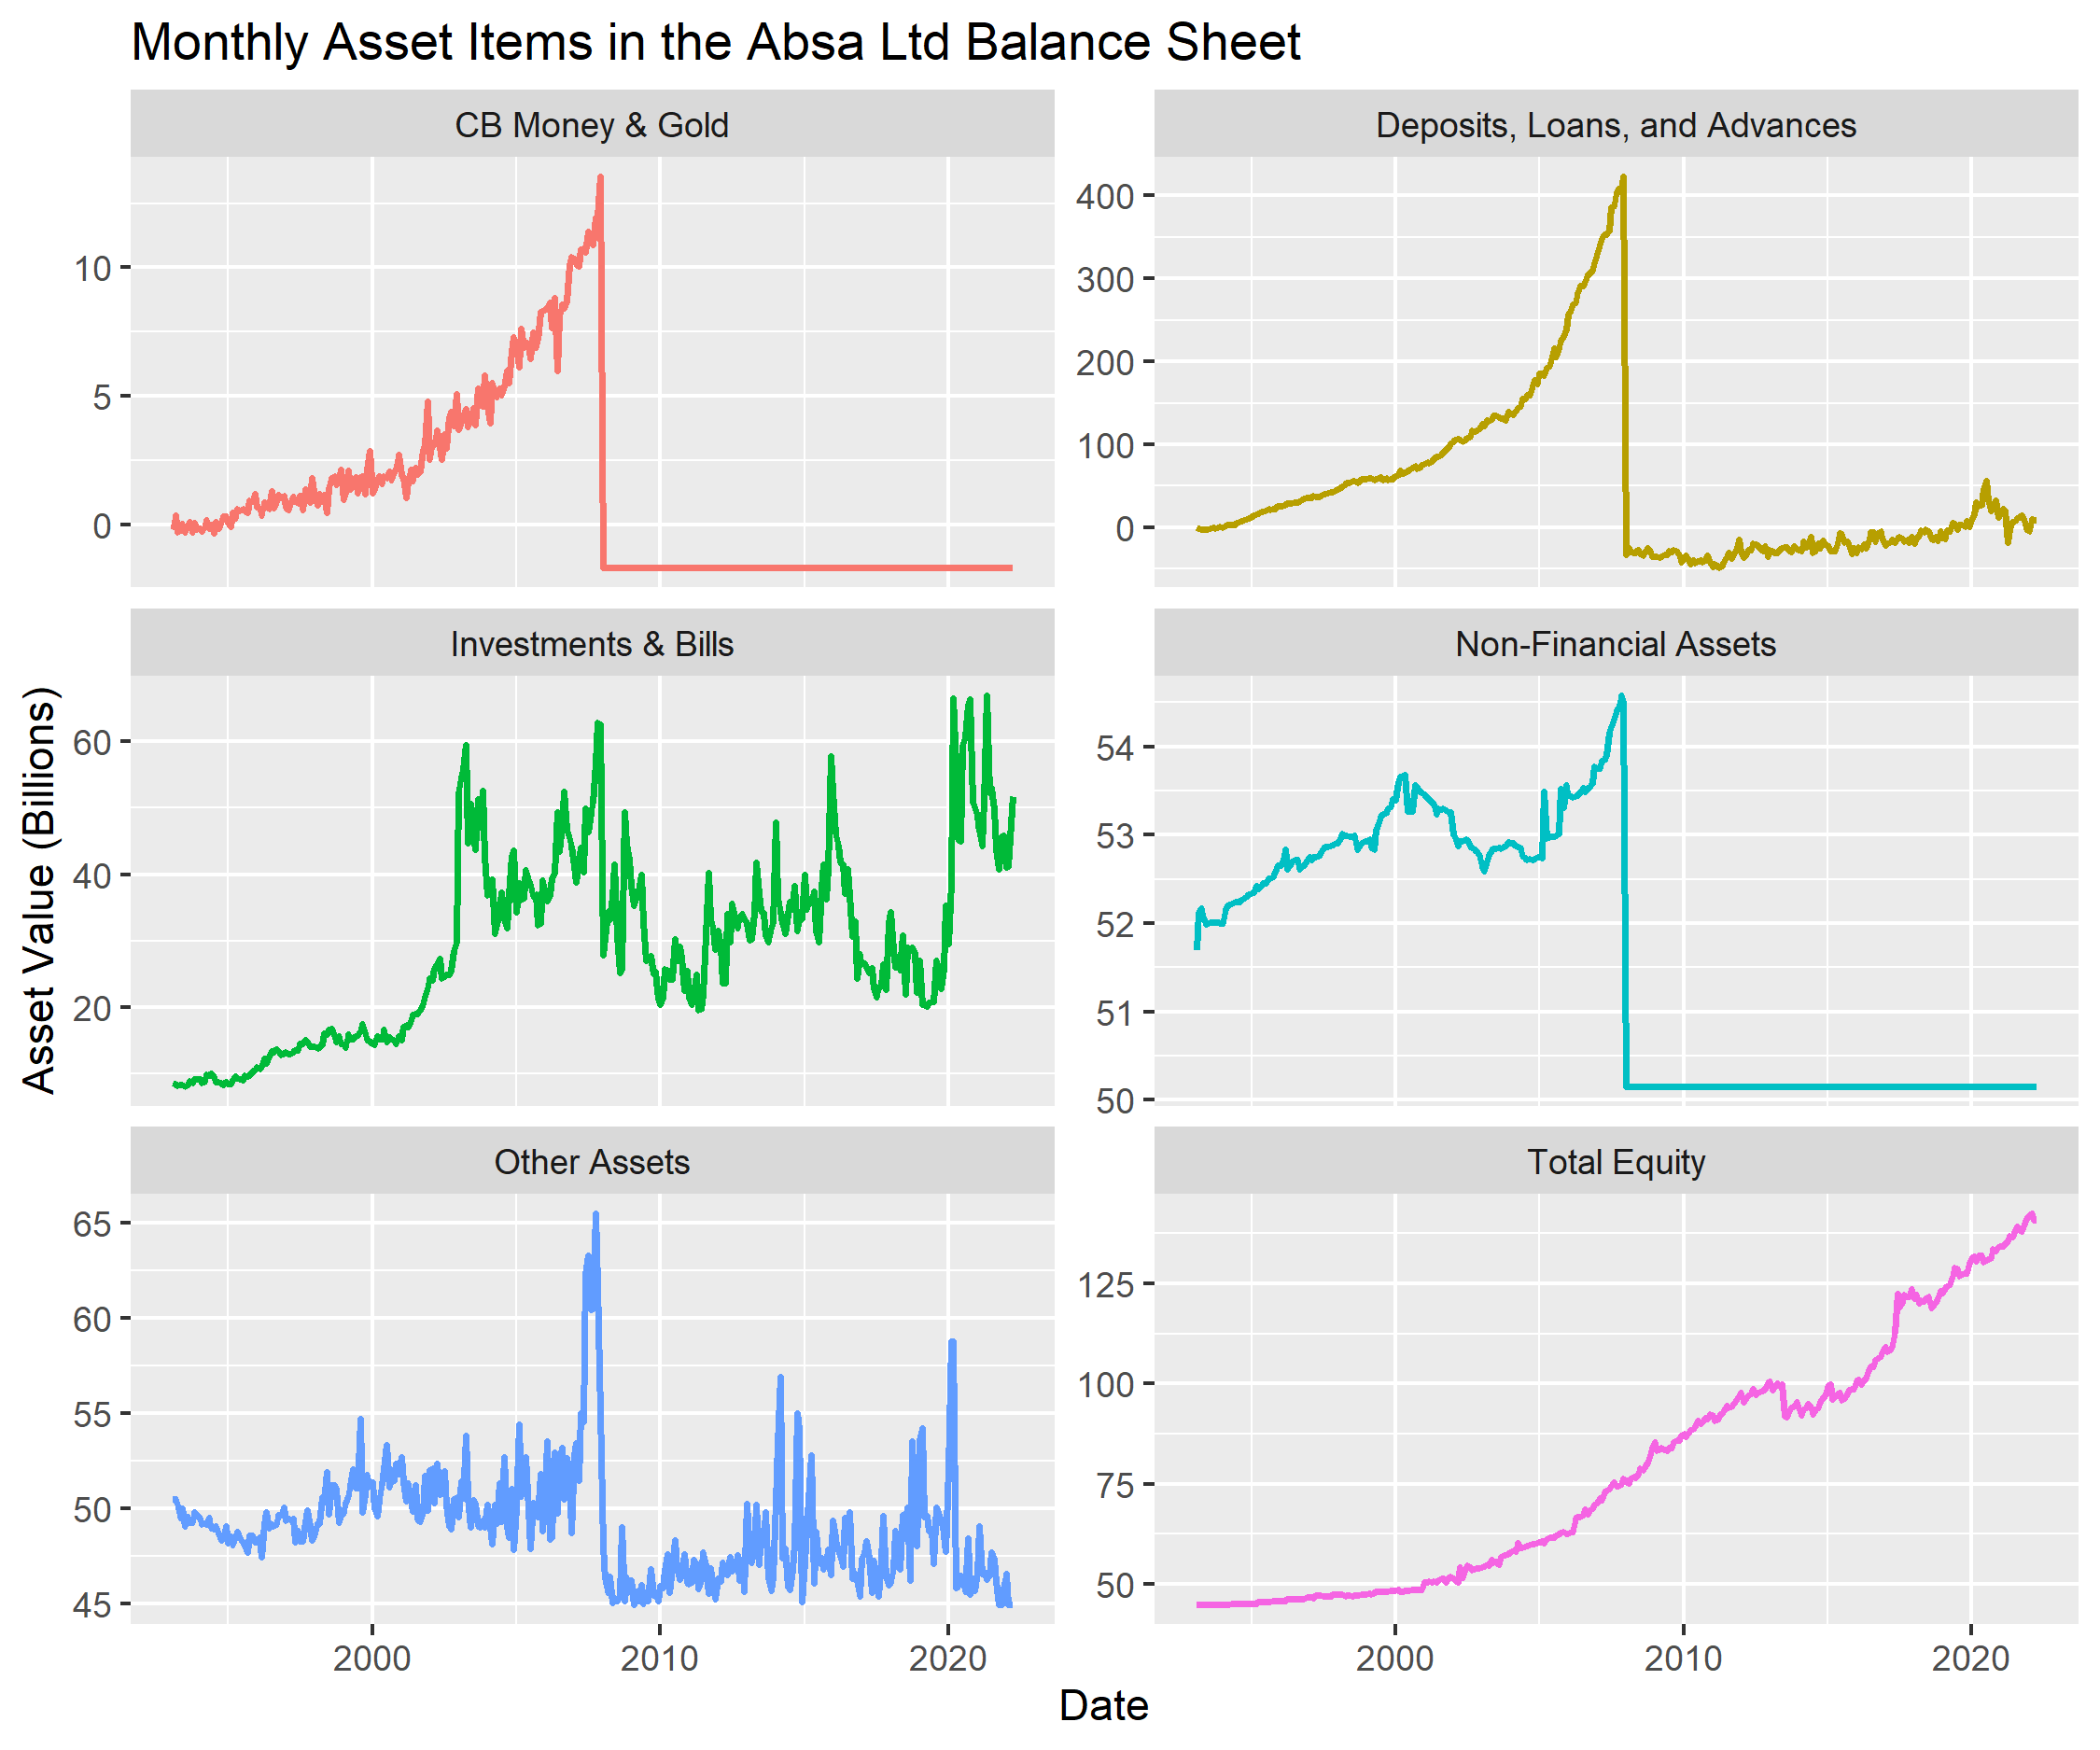

In [144]:
from IPython.display import Image
Image("./figures/missing_totals.png", width=700, height=700)

In [145]:
absa.loc[absa["Table"].str.contains("Central.{,3}Bank", regex=True, case=False),][["Table", 
                                                   " 2007M11", " 2007M12", " 2008M01", " 2008M02", " 2022M04"]]

,Table,2007M11,2007M12,2008M01,2008M02,2022M04
758,T_T06R103C18: T06R103C18: CENTRAL BANK MONEY A...,13645297.0,15190112.0,13758992.0,13315198.0,33454208.0
759,T_T06R103C19: T06R103C19: CENTRAL BANK MONEY A...,NaN,NaN,NaN,NaN,NaN
760,T_T06R103C21: T06R103C21: CENTRAL BANK MONEY A...,0.0,0.0,NaN,NaN,0.0
761,T_T06R103C22: T06R103C22: CENTRAL BANK MONEY A...,NaN,NaN,NaN,NaN,NaN
762,T_T06R103C24: T06R103C24: CENTRAL BANK MONEY A...,13645297.0,15190112.0,0.0,0.0,0.0
763,T_T06R103C25: T06R103C25: CENTRAL BANK MONEY A...,0.0,0.0,NaN,NaN,0.0


In [146]:
absa.loc[absa["Table"].str.contains("Deposits, loans", 
                                    regex=True, 
                                    case=False),]#[["Table", " 2007M11", " 2007M12", " 2008M01", " 2008M02"]]

,Bank,Table,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,...,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03,2022M04
807,Absa_Bank_Ltd,"T_T06R110C18: T06R110C18: DEPOSITS, LOANS AND ...",64047968.0,65947855.0,64696818.0,63307284.0,63139892.0,63178459.0,64254248.0,65044752.0,...,900001589.0,912977212.0,926291034.0,930239471.0,973512169.0,956047585.0,938001855.0,941540133.0,942356062.0,952401151.0
808,Absa_Bank_Ltd,"T_T06R110C19: T06R110C19: DEPOSITS, LOANS AND ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
809,Absa_Bank_Ltd,"T_T06R110C21: T06R110C21: DEPOSITS, LOANS AND ...",937381.0,838561.0,811696.0,504127.0,949588.0,814481.0,408669.0,369640.0,...,51067949.0,52016315.0,52100644.0,52745582.0,53468243.0,52749188.0,52977051.0,53516247.0,51851753.0,53561665.0
810,Absa_Bank_Ltd,"T_T06R110C22: T06R110C22: DEPOSITS, LOANS AND ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
811,Absa_Bank_Ltd,"T_T06R110C24: T06R110C24: DEPOSITS, LOANS AND ...",64985349.0,66786416.0,65508514.0,63811411.0,64089480.0,63992940.0,64662917.0,65414392.0,...,74529667.0,77663925.0,78899748.0,81178798.0,74540284.0,64701459.0,62134502.0,76409017.0,75906076.0,75427581.0
812,Absa_Bank_Ltd,"T_T06R110C25: T06R110C25: DEPOSITS, LOANS AND ...",NaN,NaN,NaN,51000.0,NaN,67000.0,76000.0,81000.0,...,57435201.0,60076132.0,59485984.0,58404757.0,65695050.0,51309794.0,48540893.0,59137706.0,58564677.0,58874042.0


In [147]:
absa.loc[absa["Table"].str.contains("NON-FINANCIAL", 
                                    regex=True),][["Table", 
                                                   " 2007M11", " 2007M12", " 2008M01", " 2008M02"]]

,Table,2007M11,2007M12,2008M01,2008M02
1948,T_T13R258C18: T13R258C18: NON-FINANCIAL ASSETS...,4425493.0,4360173.0,4346590.0,4354713.0
1949,T_T13R258C20: T13R258C20: NON-FINANCIAL ASSETS...,NaN,NaN,NaN,NaN
1950,T_T13R258C21: T13R258C21: NON-FINANCIAL ASSETS...,0.0,0.0,NaN,NaN
1951,T_T13R258C23: T13R258C23: NON-FINANCIAL ASSETS...,NaN,NaN,NaN,NaN
1952,T_T13R258C24: T13R258C24: NON-FINANCIAL ASSETS...,4425493.0,4360173.0,0.0,0.0
1953,T_T13R258C25: T13R258C25: NON-FINANCIAL ASSETS...,NaN,NaN,NaN,NaN


In [148]:
absa.loc[absa["Table"].str.contains("OTHER ASSETS", 
                                    regex=True),][["Table", 
                                                   " 2007M11", " 2007M12", " 2008M01", " 2008M02"]]

,Table,2007M11,2007M12,2008M01,2008M02
2011,T_T13R267C18: T13R267C18: OTHER ASSETS (total ...,16799115.0,10121892.0,19805087.0,13059691.0
2012,T_T13R267C20: T13R267C20: OTHER ASSETS (total ...,NaN,NaN,NaN,NaN
2013,T_T13R267C21: T13R267C21: OTHER ASSETS (total ...,0.0,0.0,NaN,NaN
2014,T_T13R267C23: T13R267C23: OTHER ASSETS (total ...,NaN,NaN,NaN,NaN
2015,T_T13R267C24: T13R267C24: OTHER ASSETS (total ...,16799115.0,10121892.0,3112576.0,1314520.0
2016,T_T13R267C25: T13R267C25: OTHER ASSETS (total ...,NaN,NaN,NaN,NaN


In [149]:
test1 = absa.loc[absa["Table"].str.contains("OTHER ASSETS", 
                                    regex=True),].loc[2011," 1993M01" : " 2007M12"].fillna(0)
test2 = absa.loc[absa["Table"].str.contains("OTHER ASSETS", 
                                    regex=True),].loc[2015," 1993M01" : " 2007M12"].fillna(0)
#sum(test1 == test2), len(test1)
test1[test1 != test2], test2[test1 != test2]

( 1994M04    4219413.0
 Name: 2011, dtype: float64,
  1994M04    4219944.0
 Name: 2015, dtype: float64)

In [150]:
def fill_totals(df):
    # CB money
    repl1 = df["Table"].str.contains("T_T06R103C24: T06R103C24:", regex=True, case=False)
    with1 = df["Table"].str.contains("T_T06R103C18: T06R103C18:", regex=True, case=False)

    df.loc[repl1,:] = df.loc[repl1,:].replace(list(df.loc[repl1,:].iloc[0,2:]), 1)
    df.loc[repl1, " 1993M01":] = df.loc[repl1, " 1993M01":].cumsum(axis=1)

    df.loc[repl1,:] = df.loc[repl1,:].replace(list(df.loc[repl1,:].iloc[0,2:]), 
                                                  list(df.loc[with1,:].iloc[0,2:]))
    # Deposits
    repl2 = df["Table"].str.contains("T_T06R110C24: T06R110C24:", regex=True, case=False)
    with2 = df["Table"].str.contains("T_T06R110C18: T06R110C18:", regex=True, case=False)
    joint1 = df.loc[with2,:].iloc[0,2:].add(df.loc[repl2,:].iloc[0,2:])[" 2008M01":]
    with2b = list(df.loc[repl2,:].iloc[0,2:][:" 2007M12"].append(joint1))

    df.loc[repl2,:] = df.loc[repl2,:].replace(list(df.loc[repl2,:].iloc[0,2:]), 
                                                  list(with2b))
    
    # NON-FINANCIAL ASSETS
    repl3 = df["Table"].str.contains("T_T13R258C24: T13R258C24:", regex=True, case=False)
    with3 = df["Table"].str.contains("T_T13R258C18: T13R258C18:", regex=True, case=False)
    
    df.loc[repl3,:] = df.loc[repl3,:].replace(list(df.loc[repl3,:].iloc[0,2:]), 1)
    df.loc[repl3, " 1993M01":] = df.loc[repl3, " 1993M01":].cumsum(axis=1)

    df.loc[repl3,:] = df.loc[repl3,:].replace(list(df.loc[repl3,:].iloc[0,2:]), 
                                            list(df.loc[with3,:].iloc[0,2:]))
    
    # OTHER ASSETS
    repl4 = df["Table"].str.contains("T_T13R267C24: T13R267C24:", regex=True, case=False)
    with4a = df["Table"].str.contains("T_T13R267C21: T13R267C21:", regex=True, case=False)
    with4b = df["Table"].str.contains("T_T13R267C18: T13R267C18:", regex=True, case=False)
    joint2 = df.loc[with4a,:].fillna(0).iloc[0,2:].add(df.loc[with4b,:].fillna(0).iloc[0,2:])

    df.loc[repl4,:] = df.loc[repl4,:].replace(list(df.loc[repl4,:].iloc[0,2:]), 
                                            list(joint2))
    
    return(df)

In [151]:
absa = fill_totals(absa)

C:\Users\gerar\AppData\Local\Temp\ipykernel_20760\3008019174.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with2b = list(df.loc[repl2,:].iloc[0,2:][:" 2007M12"].append(joint1))


In [152]:
absa = clean_names2(absa)

In [153]:
absa.head(1)

,Bank,Table,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,...,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03,2022M04
0,Absa_Bank_Ltd,T_T01: Table 1: LIABILITIES AT MONTH-END,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
list(absa["Table"])[:6]

['T_T01: Table 1: LIABILITIES AT MONTH-END',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): Cheque (1)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): Savings (2)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): Up to 1 day (3)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): More than 1 day to 1 month (4)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): More than 1 month to 6 months (5)']

In [155]:
list(absa[absa["Table"].str.contains("total", case=False)]["Table"])[:6]

['L_T1-2_R001_DEPOSITS (total of items 2 and 32): Cheque (1)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): Savings (2)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): Up to 1 day (3)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): More than 1 day to 1 month (4)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): More than 1 month to 6 months (5)',
 'L_T1-2_R001_DEPOSITS (total of items 2 and 32): More than 6 months (6)']

So we want to exclude several types of columns. That is, 

Those not containing the uppercase label `TOTAL`

First, to make things easier, the data is split into the three

major components of the Balance Sheet. That is, liabilities, 
assets, and equity

The dataframe must frist be transposed to ensure
it is in the correct form for the model from the start

In [156]:
list(absa.loc[absa["Table"].str.contains("TOTAL"),:]["Table"])[:6]

['L_T1-2_R001_DEPOSITS (total of items 2 and 32): TOTAL (7)',
 'L_T1-2_R002_DEPOSITS DENOMINATED IN RAND (total of items 3 6 12 13 and 29): TOTAL (7)',
 'L_T1-2_R003_SA banksb (total of items 4 and 5): TOTAL (7)',
 'L_T1-2_R004_NCDs/PNsi: TOTAL (7)',
 'L_T1-2_R005_Other deposits: TOTAL (7)',
 'L_T1-2_R006_Central and provincial government sector depositsc (total of items 7 10 and 11): TOTAL (7)']

It is clear from the above that the columns containing enough

aggregated information are tagged with `(total of items ...)`

so this can be filtered

In [157]:
def filter_totals(df):
    df = df.loc[df["Table"].str.contains("TOTAL"),:]
    df = df.loc[df["Table"].str.contains("[(]total of items ", regex=True), :]
    dups = df["Table"].str.replace(".*(R[0-9]{3}).*", regex=True, repl=r"\1").duplicated()
    df = df.loc[~dups,:]
    return(df)

In [158]:
absa = filter_totals(absa)

In [159]:
InteractiveShell.ast_node_interactivity = "all"

In [160]:
absa.head(1)
absa.info()

,Bank,Table,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,...,2021M07,2021M08,2021M09,2021M10,2021M11,2021M12,2022M01,2022M02,2022M03,2022M04
8,Absa_Bank_Ltd,L_T1-2_R001_DEPOSITS (total of items 2 and 32)...,66036932.0,65948319.0,66446620.0,64813147.0,64317315.0,65148147.0,64450271.0,66006474.0,...,987428308.0,978982466.0,990882087.0,1.002621e+09,1.026975e+09,1.025364e+09,997923770.0,1.011085e+09,1.022591e+09,1.048495e+09


<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 8 to 2081
Columns: 354 entries, Bank to  2022M04
dtypes: float64(352), object(2)
memory usage: 185.8+ KB


In [161]:
InteractiveShell.ast_node_interactivity = "last"

In [162]:
def reformat(df):
    df = df.drop("Bank", axis=1)
    df = df.set_index("Table").T
    df.columns.name = None
    df.index.name = "Date"
    df.index = pd.to_datetime(df.index, format=" %YM%m")
    df.columns = df.columns.str.replace(pat=" ", repl="_")
    df.columns = df.columns.str.replace(pat="total_of_items", repl="tot")
    df = df.apply(pd.to_numeric)
    
    return(df)

In [163]:
absa = reformat(absa)

In [164]:
def liabilities(df):
    df = df.iloc[:,df.columns.str.startswith(("L_"))]
    return(df)

def equity(df):
    df = df.iloc[:,df.columns.str.startswith(("E_"))]
    return(df)

def assets(df):
    df = df.iloc[:,df.columns.str.startswith(("A_"))]
    return(df)

In [165]:
absa_l = liabilities(absa)
absa_e = equity(absa)
absa_a = assets(absa)

In [166]:
list(absa_l.iloc[:,
                absa_l.columns.str.contains("L_T[13]-[24]_R[0-9]{3}_[A-Z]{3,}")].columns[1:-1])

['L_T1-2_R002_DEPOSITS_DENOMINATED_IN_RAND_(tot_3_6_12_13_and_29):_TOTAL_(7)',
 'L_T1-2_R032_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_(tot_33_to_38):_TOTAL_(7)',
 'L_T3-4_R041_OTHER_BORROWED_FUNDS_(tot_42_51_and_57):_TOTAL_(4)',
 'L_T3-4_R058_FOREIGN_CURRENCY_FUNDING_(tot_59_to_63_and_66):_TOTAL_(4)',
 'L_T3-4_R067_OTHER_LIABILITIES_TO_THE_PUBLIC_(tot_68_73_74_and_77):_TOTAL_(4)',
 'L_T3-4_R078_TOTAL_LIABILITIES_TO_THE_PUBLIC_(tot_1_41_58_and_67):_Short-term_(1)',
 'L_T3-4_R080_OTHER_LIABILITIES_(tot_81_85_86_90_91_and_94):_TOTAL_(4)']

In [167]:
list(absa_e.columns[:-2])

['E_T5_R096_TOTAL_EQUITY_(tot_97_and_101):_TOTAL_(1)']

In [168]:
absa_a.iloc[:,absa_a.columns.str.contains("A_T6-13_R[0-9]{3}_[A-Z-]{4,}")].columns[:-1]

Index(['A_T6-13_R103_CENTRAL_BANK_MONEY_AND_GOLD_(tot_104_to_106):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5)',
       'A_T6-13_R110_DEPOSITS_LOANS_AND_ADVANCES_(tot_111_117_118_126_135_139_150_166_171_and_180_less_item_194):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5)',
       'A_T6-13_R195_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_(tot_196_207_213_217_221_225_229_233_237_241_and_246_less_item_245):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5)',
       'A_T6-13_R258_NON-FINANCIAL_ASSETS_(tot_259_and_264):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5)',
       'A_T6-13_R267_OTHER_ASSETS_(tot_268_to_272_and_276):_TOTAL_ASSETS_(Col_1_plus_col_3)_(5)'],
      dtype='object')

The columns referring to `RXXX` indexes prior to its own

will be removed, and the the `tot_XXX` columns referred to in the 

brackets above will be used to include more information


In [169]:
def clean_liab(df):
    keep = list(df.iloc[:,
                            df.columns.str.contains("L_T[13]-[24]_R[0-9]{3}_[A-Z]{3,}")].columns[1:-1])
    del keep[-2]
    df = df[keep]
    df.columns = df.columns.str.replace("T[13]-[24]_R[0-9]{3}_", "", regex=True)
    df.columns = df.columns.str.replace("_[(].*[)]:", "", regex=True)
    df.columns = df.columns.str.replace("_[(][0-9][)]", "", regex=True)
    return(df)

def clean_assets(df):
    keep = list(df.iloc[:,
                            df.columns.str.contains("A_T6-13_R[0-9]{3}_[A-Z-]{4,}")].columns[:-1])
    df = df[keep]
    df.columns = df.columns.str.replace("T6-13_R[0-9]{3}_", "", regex=True)
    df.columns = df.columns.str.replace("_[(].*[)]:", "", regex=True)
    df.columns = df.columns.str.replace("_[(][0-9][)]", "", regex=True)
    df.columns = df.columns.str.replace("_[(].*[)]", "", regex=True)
    return(df)

def clean_equity(df):
    keep = list(df.columns[:-2])
    df = df[keep]
    df.columns = df.columns.str.replace("T5_R[0-9]{3}_", "", regex=True)
    df.columns = df.columns.str.replace("_[(].*[)]:", "", regex=True)
    df.columns = df.columns.str.replace("_[(][0-9][)]", "", regex=True)
    return(df)

In [170]:
absa_l = clean_liab(absa_l)
absa_e = clean_equity(absa_e)
absa_a = clean_assets(absa_a)

In [171]:
def join_diff(liab, ass, eq, bank="ABSA"):
    df = pd.concat([liab, ass, eq], axis = 1)
#     df = df.replace(0, 1)
#     df = df.fillna(1)
    df = df.fillna(0)
#     df = np.log(df)
    df = df.diff()
    df = df.iloc[1:,:]
    df.insert(0, "Bank", bank)
    return(df)

In [172]:
absa = join_diff(absa_l, absa_a, absa_e)

In [173]:
check_file("absa2.csv")

'C:\\GitHub\\DS_PROJ\\data\\absa2.csv'

In [174]:
# Call the following to see a clear picture of the sequence of 
# steps to clean each of the banks' datasets.
[ f for f in globals().values() if inspect.isfunction(f) ]

[<function platform.python_version()>,
 <function __main__.view_files()>,
 <function __main__.check_file(file)>,
 <function __main__.import_data(path)>,
 <function __main__.clean_names1(df, bank_prefix='B_34118: ')>,
 <function __main__.remove_empty(df)>,
 <function __main__.clean_names2(df)>,
 <function __main__.fill_totals(df)>,
 <function __main__.filter_totals(df)>,
 <function __main__.reformat(df)>,
 <function __main__.liabilities(df)>,
 <function __main__.equity(df)>,
 <function __main__.assets(df)>,
 <function __main__.clean_liab(df)>,
 <function __main__.clean_assets(df)>,
 <function __main__.clean_equity(df)>,
 <function __main__.join_diff(liab, ass, eq, bank='ABSA')>,
 <function __main__.join_banks(df1, df2, df3, df4, df5, df6)>,
 <function __main__.wrangle_shares(df)>,
 <function __main__.quarter_delay(banks_df, shares_df)>,
 <function __main__.month_delay(banks_df, shares_df)>,
 <function __main__.compare_corr()>]

In [175]:
view_files()

['absa2.csv',
 'absa_jup.csv',
 'AllShares_growth.csv',
 'banks_data.csv',
 'capitec.csv',
 'feature_imp_select.csv',
 'fnb.csv',
 'household_financial_assets-currency_and_deposits.csv',
 'investec.csv',
 'investment_Qgrowth.csv',
 'inv_by_assets_intellectual.csv',
 'nedbank.csv',
 'share_prices.csv',
 'standard_bank.csv']

In [176]:
check_file("standard_bank.csv")

'C:\\GitHub\\DS_PROJ\\data\\standard_bank.csv'

In [177]:
absa.to_csv("C:/GitHub/DS_PROJ/data/absa_jup.csv")

In [178]:
standard_bank = reformat(filter_totals(clean_names2(fill_totals(
    remove_empty(clean_names1(import_data(check_file("standard_bank.csv")), 
                                                                     bank_prefix="B_416061: "))))))
standard_bank
l_std = clean_liab(liabilities(standard_bank))
e_std = clean_equity(equity(standard_bank))
a_std = clean_assets(assets(standard_bank))

standard_bank = join_diff(l_std, e_std, a_std, bank="STANDARD_BANK")
standard_bank.head(1)

C:\Users\gerar\AppData\Local\Temp\ipykernel_20760\3008019174.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with2b = list(df.loc[repl2,:].iloc[0,2:][:" 2007M12"].append(joint1))


,Bank,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL,L_OTHER_LIABILITIES_TOTAL,E_TOTAL_EQUITY_TOTAL,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS
Date,,,,,,,,,,,,,
1993-02-01,STANDARD_BANK,-420910.0,-3967.0,-314590.0,-58478.0,113171.0,87232.0,152636.0,-89264.0,-899615.0,173511.0,-394.0,160439.0


In [179]:
fnb = reformat(filter_totals(clean_names2(fill_totals(
    remove_empty(clean_names1(import_data(check_file("fnb.csv")), 
                                        bank_prefix=""))))))
fnb
l = clean_liab(liabilities(fnb))
e = clean_equity(equity(fnb))
a = clean_assets(assets(fnb))

fnb = join_diff(l, e, a, bank="FNB")
fnb.head(1)

C:\Users\gerar\AppData\Local\Temp\ipykernel_20760\3008019174.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with2b = list(df.loc[repl2,:].iloc[0,2:][:" 2007M12"].append(joint1))


,Bank,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL,L_OTHER_LIABILITIES_TOTAL,E_TOTAL_EQUITY_TOTAL,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS
Date,,,,,,,,,,,,,
1993-02-01,FNB,1325346.0,128151.0,27282.0,-252496.0,-1150666.0,-105941.0,239.0,-104879.0,315014.0,-185054.0,37124.0,-130543.0


In [180]:
nedbank = reformat(filter_totals(clean_names2(fill_totals(
    remove_empty(clean_names1(import_data(check_file("nedbank.csv")), 
                                                                     bank_prefix=""))))))
nedbank
l = clean_liab(liabilities(nedbank))
e = clean_equity(equity(nedbank))
a = clean_assets(assets(nedbank))

nedbank = join_diff(l, e, a, bank="NEDBANK")
nedbank.head(1)

C:\Users\gerar\AppData\Local\Temp\ipykernel_20760\3008019174.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with2b = list(df.loc[repl2,:].iloc[0,2:][:" 2007M12"].append(joint1))


,Bank,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL,L_OTHER_LIABILITIES_TOTAL,E_TOTAL_EQUITY_TOTAL,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS
Date,,,,,,,,,,,,,
1993-02-01,NEDBANK,-353276.0,-59594.0,-38339.0,-21189.0,73316.0,24800.0,-21486.0,51383.0,222317.0,-491901.0,43588.0,-196910.0


In [181]:
investec = reformat(filter_totals(clean_names2(fill_totals(
    remove_empty(clean_names1(import_data(check_file("investec.csv")), 
                                                                     bank_prefix=""))))))
investec
l = clean_liab(liabilities(investec))
e = clean_equity(equity(investec))
a = clean_assets(assets(investec))

investec = join_diff(l, e, a, bank="INVESTEC")
investec.head(1)

C:\Users\gerar\AppData\Local\Temp\ipykernel_20760\3008019174.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with2b = list(df.loc[repl2,:].iloc[0,2:][:" 2007M12"].append(joint1))


,Bank,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL,L_OTHER_LIABILITIES_TOTAL,E_TOTAL_EQUITY_TOTAL,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS
Date,,,,,,,,,,,,,
1993-02-01,INVESTEC,96785.0,0.0,4125.0,-877.0,3866.0,0.0,5918.0,-926.0,129179.0,-4823.0,853.0,-2350.0


In [182]:
capitec = reformat(filter_totals(clean_names2(fill_totals(
    remove_empty(clean_names1(import_data(check_file("capitec.csv")), 
                                                                     bank_prefix=""))))))
capitec
l = clean_liab(liabilities(capitec))
e = clean_equity(equity(capitec))
a = clean_assets(assets(capitec))

capitec = join_diff(l, e, a, bank="CAPITEC")
capitec.head(1)

C:\Users\gerar\AppData\Local\Temp\ipykernel_20760\3008019174.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with2b = list(df.loc[repl2,:].iloc[0,2:][:" 2007M12"].append(joint1))


,Bank,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL,L_OTHER_LIABILITIES_TOTAL,E_TOTAL_EQUITY_TOTAL,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS
Date,,,,,,,,,,,,,
1993-02-01,CAPITEC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Aggregating the Banks Together

In [183]:
def join_banks(df1, df2, df3, df4, df5, df6):
    df = reduce(lambda a, b: a.add(b, fill_value=0), [df1, df2, df3, df4, df5, df6])
    df = df.drop("Bank", axis=1)
    return(df)

In [184]:
banks = join_banks(absa, standard_bank, nedbank, fnb, capitec, investec)

In [185]:
banks.head(1)

,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS,E_TOTAL_EQUITY_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_OTHER_LIABILITIES_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL
Date,,,,,,,,,,,,
1993-02-01,-327647.0,1567962.0,-629455.0,83391.0,143264.0,137307.0,64119.0,559803.0,-236352.0,1071988.0,367124.0,-687740.0


In [186]:
banks.to_csv("./data/banks_data.csv")

In [187]:
# # This dataset has a particular problem with overlapping or highly
# # correlated features that contain elements from other columns
# # Thus, we remove these highly correlated features

# def remove_corr(df):
#     df.reset_index(inplace=True)
#     es = ft.EntitySet(id="Absa_BS")
#     ent_set = es.add_dataframe(dataframe_name="Absa_Group_Ltd",
#                                 dataframe=df, 
#                                 already_sorted=False, index = "index")
    
#     fm, features = ft.dfs(entityset=ent_set,
#                       target_dataframe_name="Absa_Group_Ltd",
#                       trans_primitives=[],
#                       agg_primitives=[], 
#                       max_depth=1)
#     # From experimentation, the 0.97 threshold seems to remove the 
#     # columns that are verbatim totals of others and not removing
#     # other columns required for feature analysis.
#     # A lower threshold will be used at a later stage after some
#     # columns have been used in calculation of additional 
#     # features
#     fm = ft.selection.remove_highly_correlated_features(fm, 
#                                                         pct_corr_threshold=0.97)
#     fm.reset_index(inplace=True)
#     fm.set_index("index", inplace=True)
#     fm.columns.name = "Date"
#     fm.index.name = None

#     return(fm)

# absa = remove_corr(absa)

# Shares

In [188]:
shares = pd.read_csv("./data/share_prices.csv")
shares.head(1)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,ZAF,SHPRICE,TOT,IDX2015,M,1960-01,0.367696,NaN


In [189]:
def wrangle_shares(df):
    df = shares[["TIME", "Value"]]
    df = df.set_index("TIME")
    df.index = pd.to_datetime(df.index, format="%Y-%m")
    df = df.diff()
    df = df.loc["1993-02-01":"2022-04-01"]
    return(df)

In [190]:
shares = wrangle_shares(shares)

In [191]:
InteractiveShell.ast_node_interactivity = "all"

In [192]:
shares.head(1)
banks.head(1)

,Value
TIME,
1993-02-01,0.161575


,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS,E_TOTAL_EQUITY_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_OTHER_LIABILITIES_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL
Date,,,,,,,,,,,,
1993-02-01,-327647.0,1567962.0,-629455.0,83391.0,143264.0,137307.0,64119.0,559803.0,-236352.0,1071988.0,367124.0,-687740.0


In [193]:
shares.describe()
banks.describe()

,Value
count,351.000000
mean,0.383069
std,2.417176
min,-21.702500
25%,-0.475430
50%,0.378450
75%,1.437770
max,7.425600


,A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,A_OTHER_ASSETS_TOTAL_ASSETS,E_TOTAL_EQUITY_TOTAL,L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,L_FOREIGN_CURRENCY_FUNDING_TOTAL,L_OTHER_BORROWED_FUNDS_TOTAL,L_OTHER_LIABILITIES_TOTAL,L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL
count,3.510000e+02,3.510000e+02,3.510000e+02,3.510000e+02,3.510000e+02,3.510000e+02,3.510000e+02,3.510000e+02,3.510000e+02,3.510000e+02,3.510000e+02,3.510000e+02
mean,4.522916e+05,1.216169e+07,7.703279e+05,2.380714e+05,2.597255e+05,1.251278e+06,6.527960e+05,1.210421e+07,2.923482e+05,5.795071e+05,1.438985e+06,1.168575e+06
std,4.388543e+06,2.469413e+07,1.943875e+07,7.220150e+05,6.272783e+06,2.918968e+06,5.364917e+06,2.252057e+07,8.627608e+06,8.963922e+06,2.793051e+07,4.931576e+06
min,-3.286008e+07,-6.296183e+07,-1.915898e+08,-3.097381e+06,-2.992281e+07,-1.038261e+07,-2.428134e+07,-8.141831e+07,-4.037649e+07,-3.680302e+07,-6.614101e+07,-1.316763e+07
25%,-9.751130e+05,1.065199e+06,-5.354569e+06,-1.842232e+04,-2.282324e+06,2.306700e+04,-9.084105e+05,4.027476e+05,-2.348286e+06,-2.627997e+06,-9.501097e+06,-8.986175e+05
50%,3.522990e+05,6.731999e+06,4.978690e+05,9.156500e+04,1.432640e+05,7.013292e+05,1.480770e+05,6.593286e+06,1.650020e+05,2.978050e+05,2.458900e+04,4.196943e+05
75%,1.695969e+06,2.046875e+07,4.663307e+06,4.029994e+05,2.710220e+06,2.390600e+06,1.976295e+06,2.406895e+07,3.190577e+06,3.645654e+06,6.042989e+06,2.304931e+06
max,3.266915e+07,1.617355e+08,1.112526e+08,9.287935e+06,2.450820e+07,1.501661e+07,3.276245e+07,1.102514e+08,4.316232e+07,3.045689e+07,2.447002e+08,5.659738e+07


In [194]:
InteractiveShell.ast_node_interactivity = "last"

# Correlation Analysis

In [305]:
share_corr = shares.join(banks).corr()[["Value"]]
plot_names = share_corr[share_corr["Value"]<0.10].index.to_list()
share_corr.sort_values("Value", key=abs, ascending=False)

,Value
Value,1.000000
L_OTHER_LIABILITIES_TOTAL,-0.366697
A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,-0.300625
L_FOREIGN_CURRENCY_FUNDING_TOTAL,-0.224657
A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,-0.204616
A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,-0.201991
L_OTHER_BORROWED_FUNDS_TOTAL,-0.170269
A_OTHER_ASSETS_TOTAL_ASSETS,0.155158
L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,-0.119003
L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,-0.114247


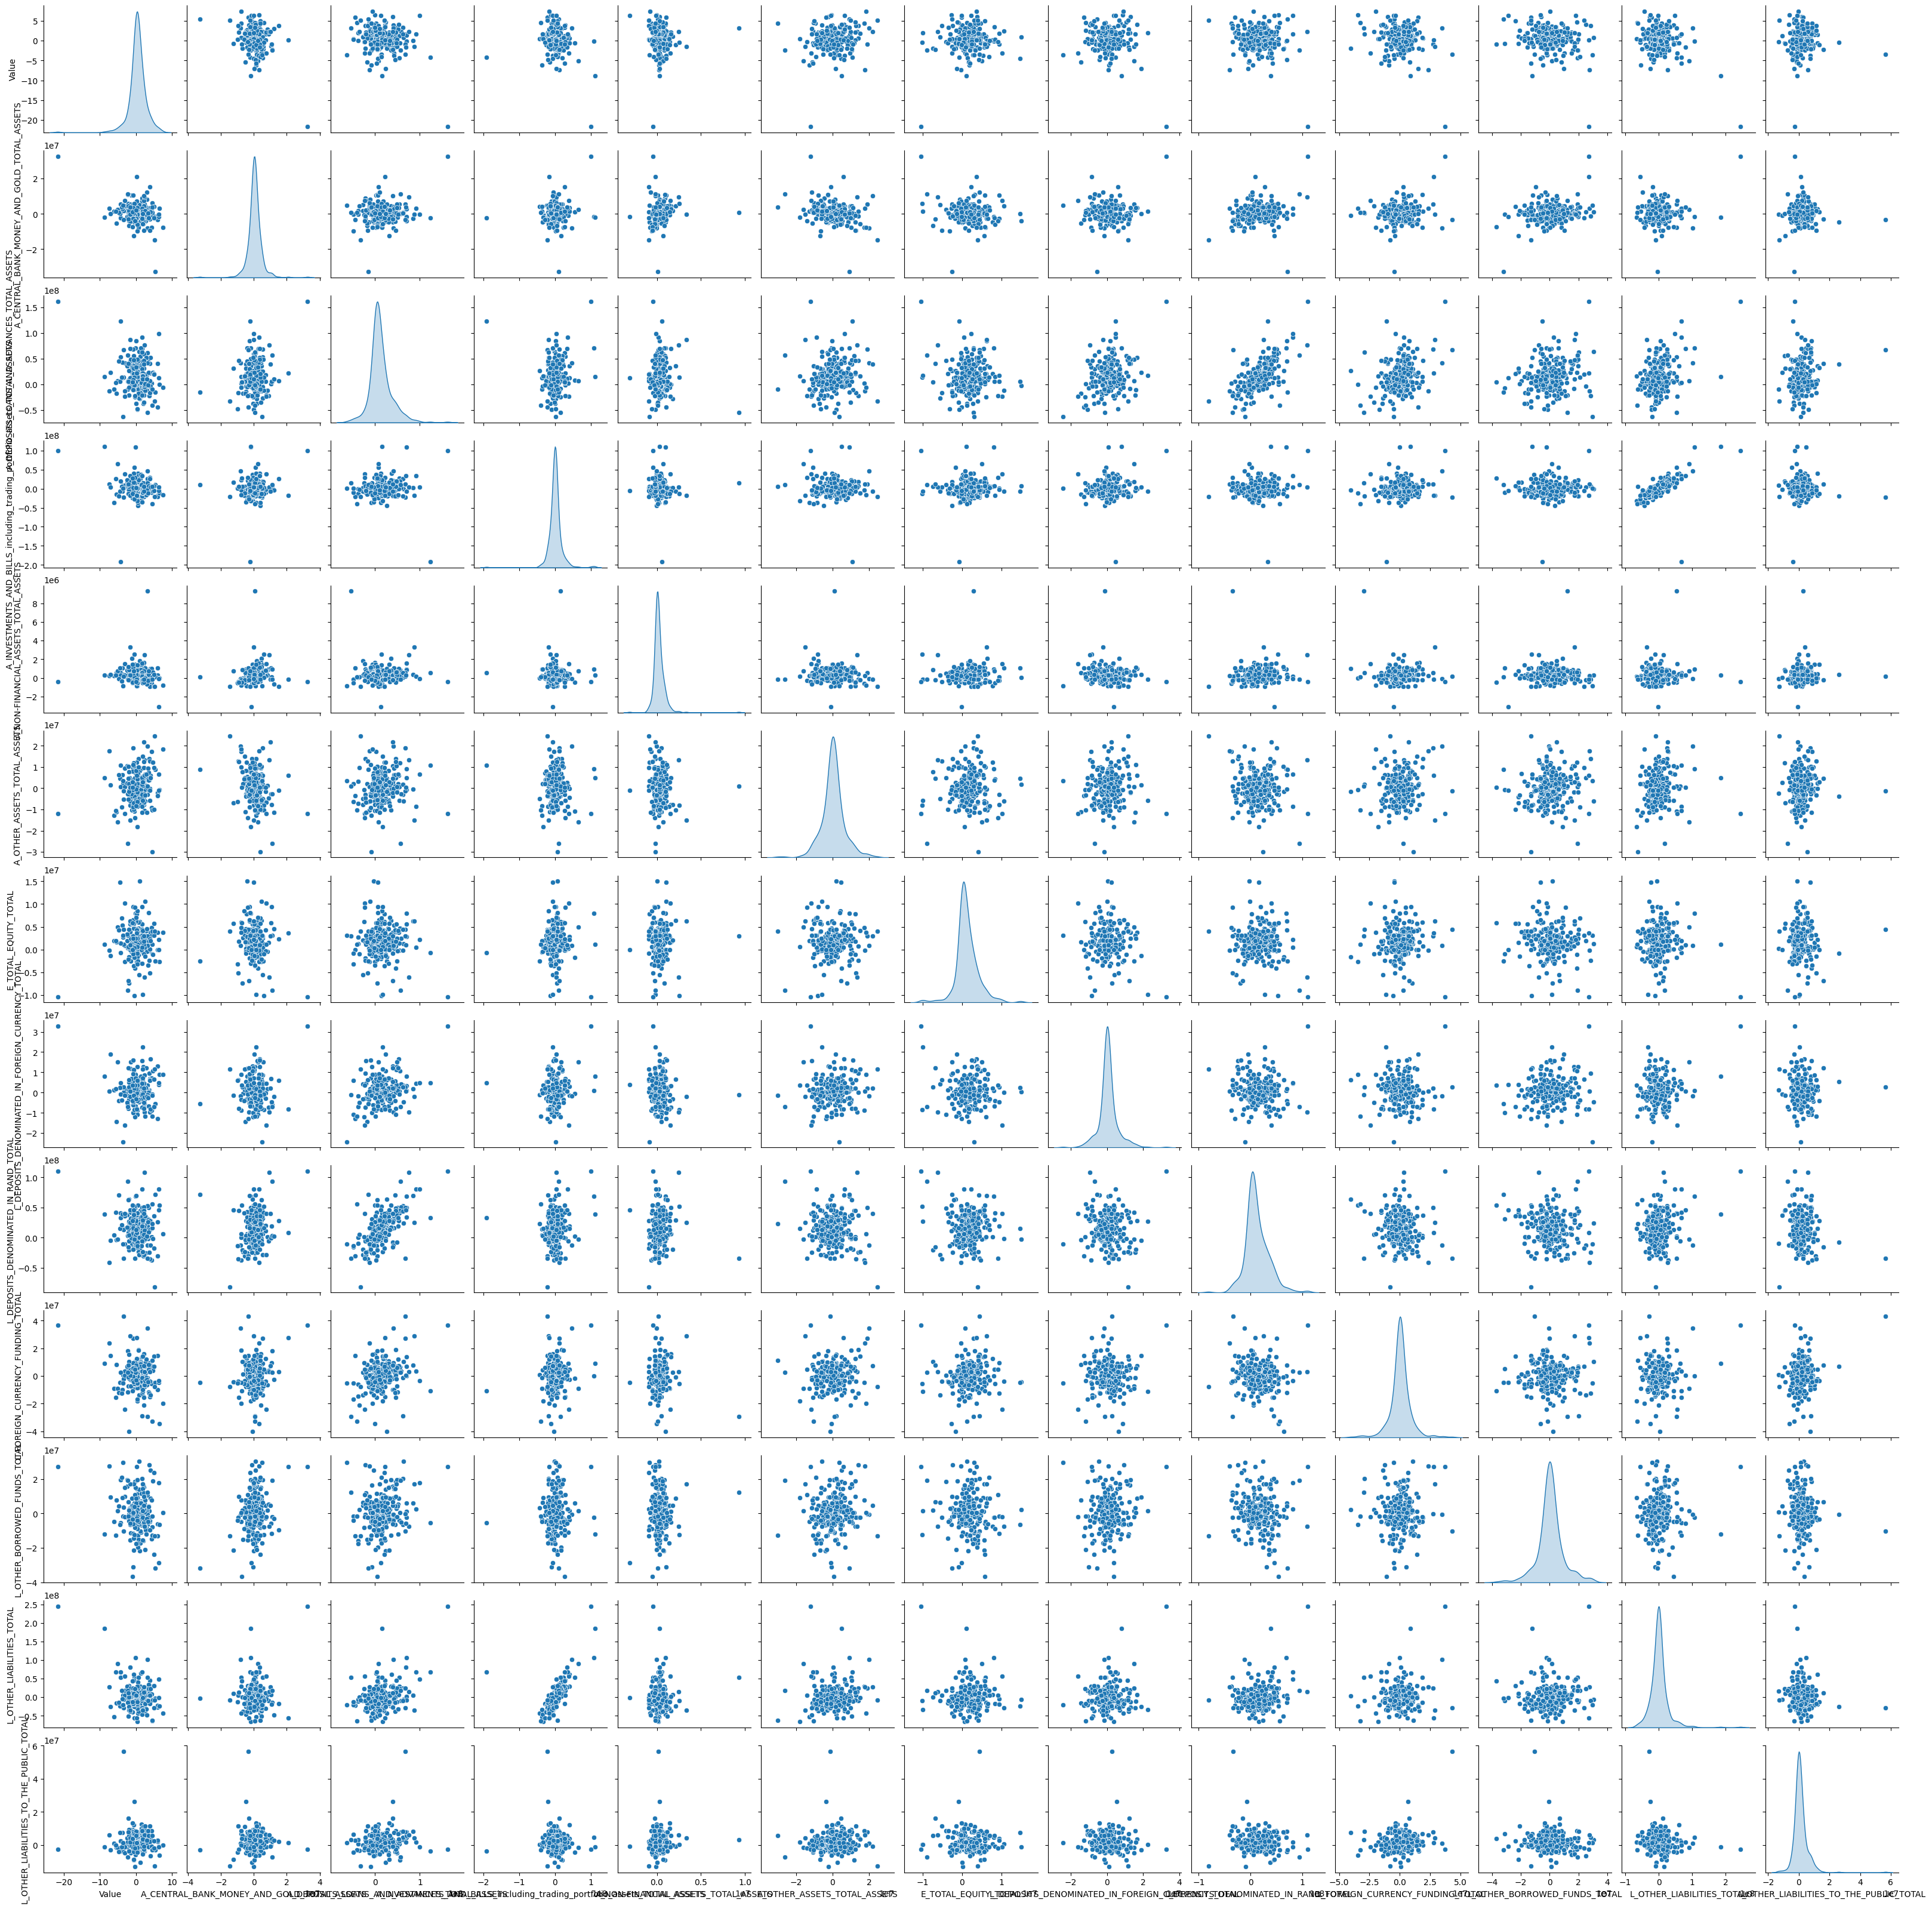

In [197]:
import seaborn as sns

sns.pairplot(shares.join(banks), diag_kind="kde")
plt.show()

In [198]:
def quarter_delay(banks_df, shares_df):
    banks_df = banks_df.shift(-3, "MS")
    joined_df = shares_df.join(banks_df, how="inner")
    shares_df = joined_df[["Value"]]
    banks_df = joined_df.iloc[:,1:]
    return(banks_df, shares_df)

In [199]:
def month_delay(banks_df, shares_df):
    banks_df = banks_df.shift(-1, "MS")
    joined_df = shares_df.join(banks_df, how="inner")
    shares_df = joined_df[["Value"]]
    banks_df = joined_df.iloc[:,1:]
    return(banks_df, shares_df)

In [200]:
qbanks, qshares = quarter_delay(banks, shares)

In [201]:
mbanks, mshares = month_delay(banks, shares)

In [318]:
def compare_corr():
    share_corr = shares.join(banks).corr()[["Value"]]
    mshare_corr = mshares.join(mbanks).corr()[["Value"]]
    qshare_corr = qshares.join(qbanks).corr()[["Value"]]
    plot_names = share_corr[share_corr["Value"]<0.10].index.to_list()
    corrSTD = share_corr.sort_values("Value", key=abs, ascending=False)
    corrM = mshare_corr.sort_values("Value", key=abs)
    corrQ = qshare_corr.sort_values("Value", key=abs)
    corrjoin1 = corrSTD.join(corrM, lsuffix="_STD", rsuffix="_M")
    corrjoin1 = corrjoin1.join(corrQ, rsuffix="_Q")
    corrjoin1["M > Q"] = abs(corrjoin1["Value_M"]) > abs(corrjoin1["Value"])
    corrjoin1.loc["Total"] = corrjoin1.sum()
    return(corrjoin1)

compare_corr()

C:\Users\gerar\AppData\Local\Temp\ipykernel_20760\2273584310.py:12: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  corrjoin1.loc["Total"] = corrjoin1.sum()


,Value_STD,Value_M,Value,M > Q
Value,1.000000,1.000000,1.000000,0.0
L_OTHER_LIABILITIES_TOTAL,-0.366697,-0.162764,-0.093664,1.0
A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,-0.300625,0.267213,-0.017780,1.0
L_FOREIGN_CURRENCY_FUNDING_TOTAL,-0.224657,-0.006258,0.029655,0.0
A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,-0.204616,0.029271,0.021923,1.0
A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,-0.201991,-0.088938,-0.118528,0.0
L_OTHER_BORROWED_FUNDS_TOTAL,-0.170269,0.148842,0.161640,0.0
A_OTHER_ASSETS_TOTAL_ASSETS,0.155158,-0.000785,0.078833,0.0
L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,-0.119003,-0.079976,0.032351,1.0
L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,-0.114247,0.020994,-0.091561,0.0


# Model

Base on the scikit-learn estimator roadmap shown below, the ideal

estimator to start with will be the `Ridge` regression estimator

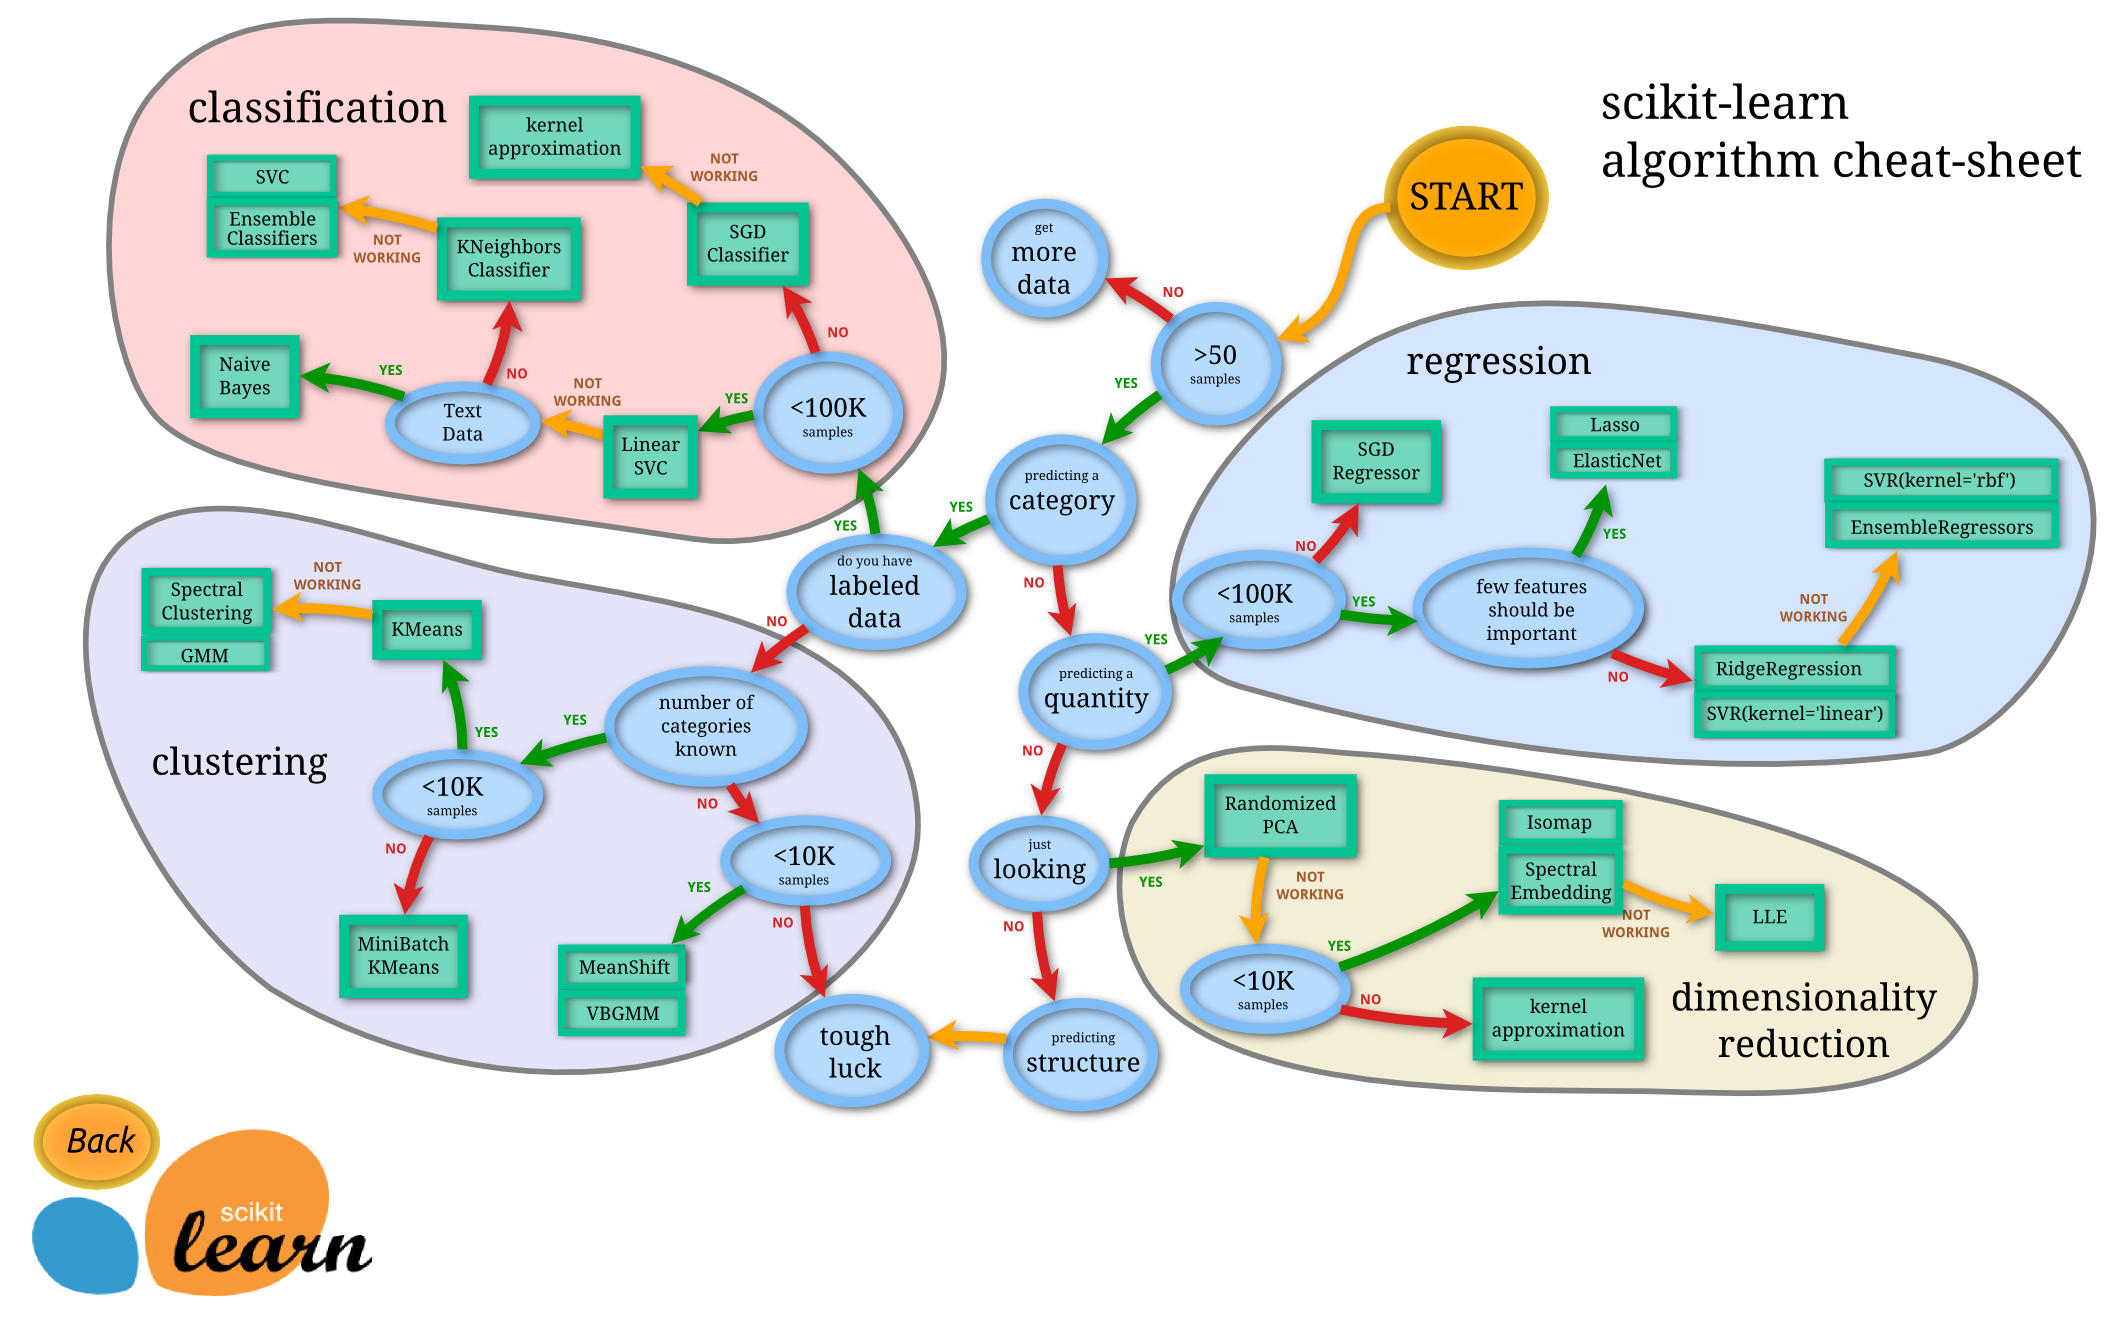

In [203]:
url='https://scikit-learn.org/stable/_static/ml_map.png'
Image(url, width=700, height=700)

## Base Model - LASSO Regression

In [204]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import TimeSeriesSplit

X = np.array(banks)
y = np.array(shares["Value"])

scaler = Normalizer()
X = scaler.fit_transform(X)

tss = TimeSeriesSplit()

ridge = Ridge()
ridge.fit(X, y)

Ridge()

In [205]:
def coeff_exaplained(df, coeff):
    features_coeff = pd.DataFrame(columns=["Feature_Coeff"])
    features = df.columns.to_list()
    j = 0
    for i in coeff:
        #print(f"{features[j]}: {i}")
        features_coeff.loc[f"{features[j]}"] = [i]
        j+=1
    features_coeff.sort_values("Feature_Coeff", ascending=False, inplace=True, key=abs)
    return(features_coeff)

In [207]:
coeff_exaplained(banks, ridge.coef_)

,Feature_Coeff
L_FOREIGN_CURRENCY_FUNDING_TOTAL,-1.827367
A_OTHER_ASSETS_TOTAL_ASSETS,1.552313
L_OTHER_BORROWED_FUNDS_TOTAL,-1.266400
L_OTHER_LIABILITIES_TOTAL,-1.066132
L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL,-0.717617
A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,0.518765
A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,-0.518271
L_DEPOSITS_DENOMINATED_IN_RAND_TOTAL,-0.420953
A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,0.273966
A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,-0.174446


In [298]:
from sklearn.model_selection import cross_val_score
def scores(X, y, model):
    '''Returns a dataframe containing the MSE & 
       R-Squared metrics of the given model, based
       on Time Series Data.'''
    tss_cv = tss.split(X)
    r_2 = cross_val_score(model, X, y, cv=tss_cv, scoring="r2")
    tss_cv = tss.split(X)
    mse = -cross_val_score(model, X, y, cv=tss_cv, scoring="neg_mean_squared_error")
    df = pd.DataFrame({ "Mean Squared Error": mse,
                        "R-Squared": r_2})
    df.loc["Avg:"] = df.mean()
    return(df)

In [299]:
scores(X, y, ridge)

,Mean Squared Error,R-Squared
0,0.848074,0.018859
1,1.964489,-0.329888
2,5.703828,-0.032767
3,6.526641,-0.002001
4,19.535861,0.033194
Avg:,6.915779,-0.062521


## Alternative Model - Random Forest Regressor

In [212]:
from sklearn.ensemble import RandomForestRegressor

In [213]:
forest = RandomForestRegressor(oob_score=True)
forest.fit(X, y)

RandomForestRegressor(oob_score=True)

In [214]:
forest.feature_importances_

array([0.06328699, 0.07389115, 0.07221602, 0.07571316, 0.04447528,
       0.09465836, 0.12444375, 0.04778264, 0.08194008, 0.06634582,
       0.20481754, 0.0504292 ])

In [215]:
def features_exaplained(df, imp):
    features_imp = pd.DataFrame(columns=["Feature_Importance"])
    features = df.columns.to_list()
    j = 0
    for i in imp:
        #print(f"{features[j]}: {i}")
        features_imp.loc[f"{features[j]}"] = [i]
        j+=1
    features_imp.sort_values("Feature_Importance", ascending=False, inplace=True)
    features_imp.loc["Total"] = features_imp.sum()
    features_imp.loc["(The Out of Bag Score Returns: )"] = [forest.oob_score_]
    return(features_imp)

In [216]:
features_exaplained(df=banks, imp=forest.feature_importances_)

,Feature_Importance
L_OTHER_LIABILITIES_TOTAL,0.204818
L_DEPOSITS_DENOMINATED_IN_FOREIGN_CURRENCY_TOTAL,0.124444
E_TOTAL_EQUITY_TOTAL,0.094658
L_FOREIGN_CURRENCY_FUNDING_TOTAL,0.081940
A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,0.075713
A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,0.073891
A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,0.072216
L_OTHER_BORROWED_FUNDS_TOTAL,0.066346
A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,0.063287
L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL,0.050429


The feature importances displayed above illustrate the relative importance of

each of the features relative to each other. As the total column suggests, the

sum of all the feature importances is 1. To more critically analyse whether all

the features are in fact necessary in the model, an interative fitting method

is displayed below. 

In [300]:
scores(X, y, forest)

,Mean Squared Error,R-Squared
0,0.885338,-0.009199
1,1.697818,-0.185615
2,6.091990,-0.095916
3,6.936414,-0.052942
4,19.804298,0.010856
Avg:,7.083172,-0.066563


Below we apply an iterative method of cloning the original model characteristics

and retrain it multiple times by excluding each of the features in turn.

This gives a more direct picture of which variables decrease the performance of

the model instead of aiding performance.

In [219]:
from sklearn.base import clone 

def imp_df(column_names, importances):
    data = {
        'Feature': column_names,
        'Importance': importances,
    }
    df = pd.DataFrame(data) \
        .set_index('Feature') \
        .sort_values('Importance', ascending=False)

    return(df)

def feat_eval_iter(model, X, y, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    forest_clone = clone(model)
    # set random_state for comparability
    forest_clone.random_state = random_state
    # training and scoring the benchmark model
    forest_clone.fit(X, y)
    benchmark_score = forest_clone.score(X, y)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X.columns:
        forest_clone = clone(model)
        forest_clone.random_state = random_state
        forest_clone.fit(X.drop(col, axis = 1), y)
        drop_col_score = forest_clone.score(X.drop(col, axis = 1), y)
        importances.append(benchmark_score - drop_col_score)

    importances_df = imp_df(X.columns, importances)
    
    
    
    return(importances_df)

In [220]:
df_imp = feat_eval_iter(forest, banks, y)

In [221]:
df_imp.to_csv("./data/feature_imp_select.csv")
df_imp

,Importance
Feature,
L_OTHER_LIABILITIES_TOTAL,0.010823
A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,0.004781
E_TOTAL_EQUITY_TOTAL,0.004743
A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,0.003751
A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,0.002659
L_FOREIGN_CURRENCY_FUNDING_TOTAL,0.001756
A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,0.001339
A_OTHER_ASSETS_TOTAL_ASSETS,0.001244
L_OTHER_LIABILITIES_TO_THE_PUBLIC_TOTAL,-0.000045


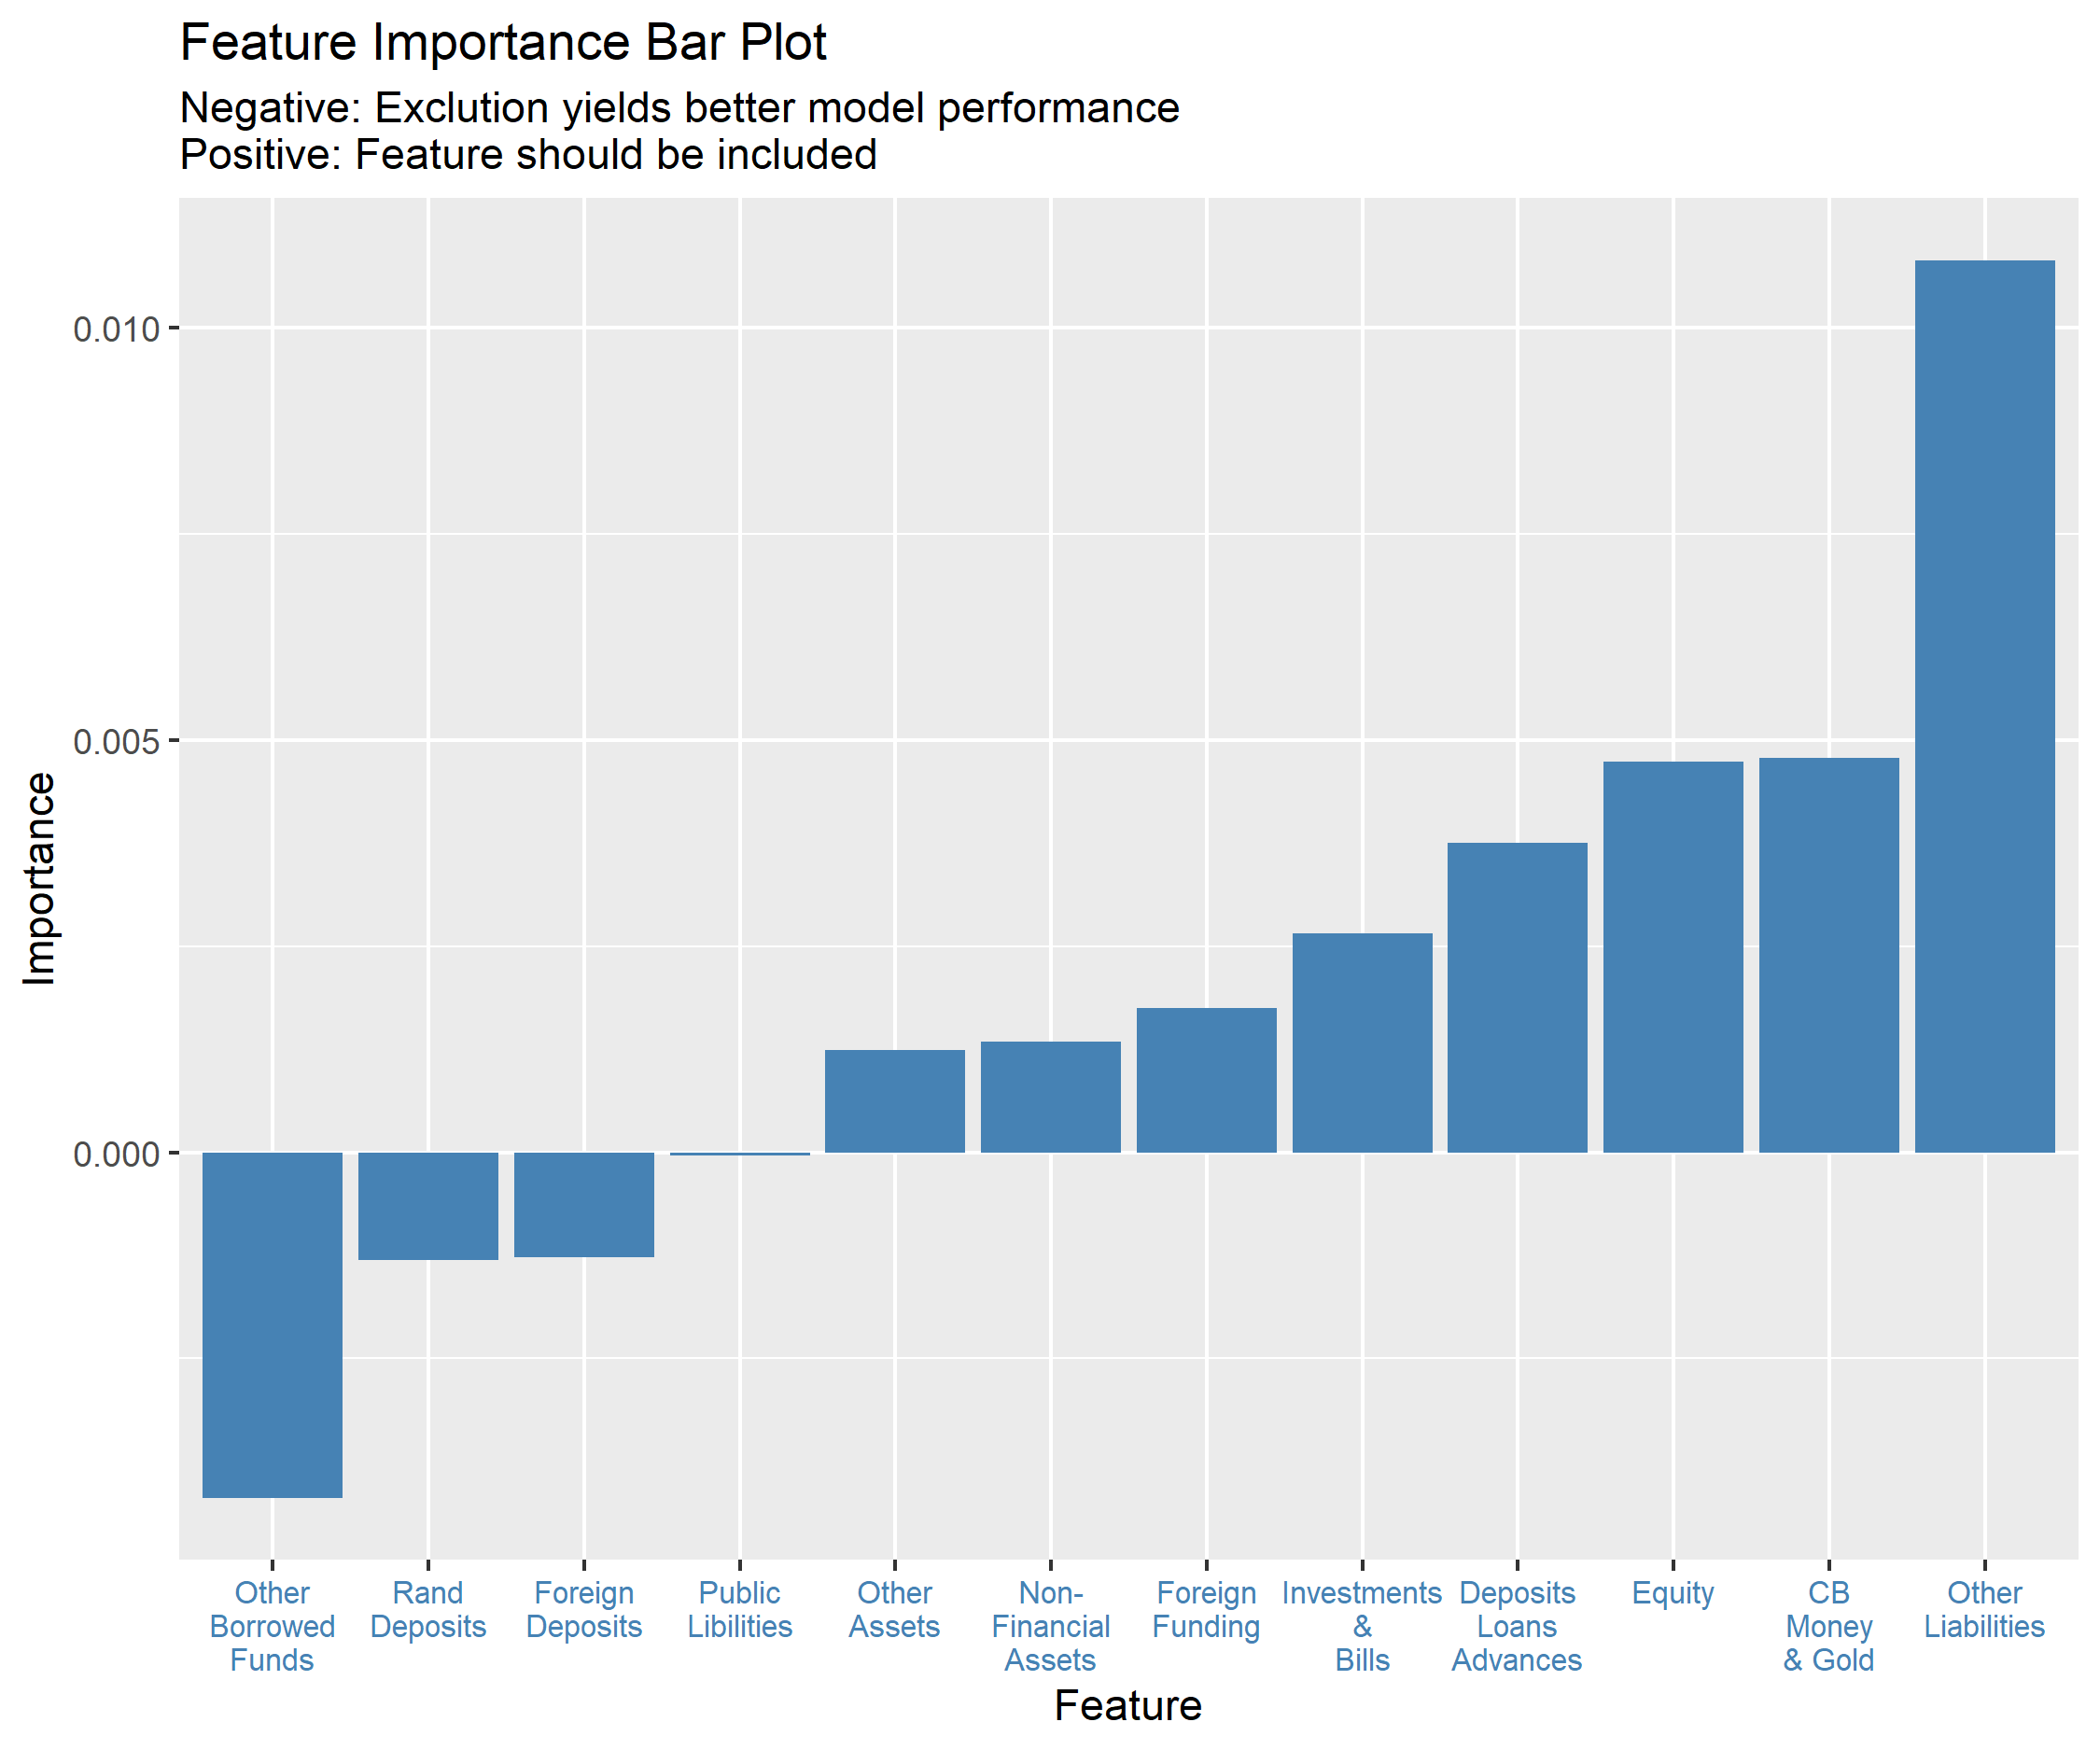

In [222]:
Image("./figures/Feature_imp_plot.png", width=700, height=700)

### Towards Improving the Model

Removing the features that decrease the model performance as the graph

above displays yields the following

In [271]:
def reduce_banks(df):
    df1 = df_imp[df_imp["Importance"]>0]
    df1 = df1.reset_index()
    df1 = df[df1["Feature"].to_list()]
    return(df1)

In [274]:
reduced_banks = reduce_banks(banks)

In [288]:
forest_reduced = RandomForestRegressor(oob_score=True)
X_reduced = np.array(reduce_banks(banks))
forest_reduced.fit(X_reduced, y)

RandomForestRegressor(oob_score=True)

In [291]:
features_exaplained(df=reduced_banks, imp=forest_reduced.feature_importances_)

,Feature_Importance
L_OTHER_LIABILITIES_TOTAL,0.213933
L_FOREIGN_CURRENCY_FUNDING_TOTAL,0.146548
A_OTHER_ASSETS_TOTAL_ASSETS,0.120271
E_TOTAL_EQUITY_TOTAL,0.114650
A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,0.114196
A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,0.105162
A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,0.097526
A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,0.087714
Total,1.000000
(The Out of Bag Score Returns: ),0.014958


The feature importances displayed above illustrate the relative importance of

each of the features relative to each other. As the total column suggests, the

sum of all the feature importances is 1. To more critically analyse whether all

the features are in fact necessary in the model, an interative fitting method

is displayed below. 

In [301]:
scores(X_reduced, y, forest_reduced)

,Mean Squared Error,R-Squared
0,0.959741,-0.110013
1,2.059789,-0.401126
2,5.896891,-0.092583
3,7.090420,-0.070799
4,17.046355,0.142885
Avg:,6.610639,-0.106327


Below we apply an iterative method of cloning the original model characteristics

and retrain it multiple times by excluding each of the features in turn.

This gives a more direct picture of which variables decrease the performance of

the model instead of aiding performance.

## Month Shift

In [312]:
X_m = reduce_banks(mbanks)
y_m = np.array(mshares["Value"])

forest_m = RandomForestRegressor(oob_score=True)
forest_m.fit(X_m, y_m)

RandomForestRegressor(oob_score=True)

In [313]:
features_exaplained(df=X_m, imp=forest_m.feature_importances_)

,Feature_Importance
A_CENTRAL_BANK_MONEY_AND_GOLD_TOTAL_ASSETS,0.238582
A_NON-FINANCIAL_ASSETS_TOTAL_ASSETS,0.153013
E_TOTAL_EQUITY_TOTAL,0.126078
L_OTHER_LIABILITIES_TOTAL,0.113915
L_FOREIGN_CURRENCY_FUNDING_TOTAL,0.101540
A_OTHER_ASSETS_TOTAL_ASSETS,0.097021
A_DEPOSITS_LOANS_AND_ADVANCES_TOTAL_ASSETS,0.096145
A_INVESTMENTS_AND_BILLS_including_trading_portfolio_assets_TOTAL_ASSETS,0.073705
Total,1.000000
(The Out of Bag Score Returns: ),0.014958


In [315]:
scores(X_m, y_m, forest_m)

,Mean Squared Error,R-Squared
0,0.869859,-0.019243
1,1.601807,-0.082968
2,5.526728,0.033243
3,7.256045,-0.171907
4,22.065188,-0.092569
Avg:,7.463925,-0.066689


A possible next step would be to consider a more aggregated dataset such as

converting the monthly data to quarterly. However, a lot of information is

lost during the process of removing overlapping columns. This is due to some

total columns originating from more than one collection of individual columns

summed together. i.e. a total column `A` can be obtained from summing together

a set of individual columns `x1`, or a different set `x2`. By removing these

individual columns, a lot of information is lost. A different model can be used

to select individual columns more systematically, such that we are left with 

columns explaining more of the variance in the shares output variable.

The results from each of the models up to now suggest that there is very

little power in the balance sheets of the top 6 banks in SA for explaining

movements in the stock market for South Africa. There seems to be some 

significant consistency across the models that `Other Liabilities` tends

to be the most siginficant relationship with south african share prices.

Additionally, the `Central Bank Money & Gold` is also regarded in the same

light, however, not in as many of the models. These two variables are also

the variables with the highest correlation with share prices in South Africa.

from sklearn.decomposition import SparsePCA

transformer = SparsePCA(n_components=5, random_state=0)
transformer.fit(mbanks)

transformer.get_params()